In [9]:
import utils
from video_transforms import Shuffle
import torch
import torchvision.transforms.v2 as ts
from pathlib import Path
import json
from video_dataset import VideoDataset
from torch.utils.data import DataLoader

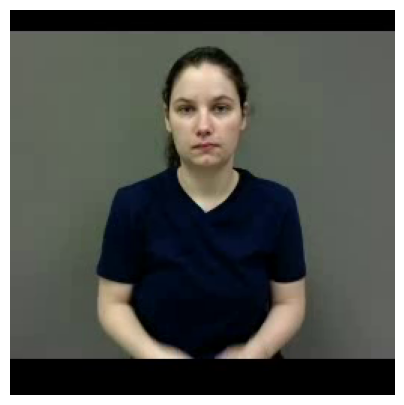

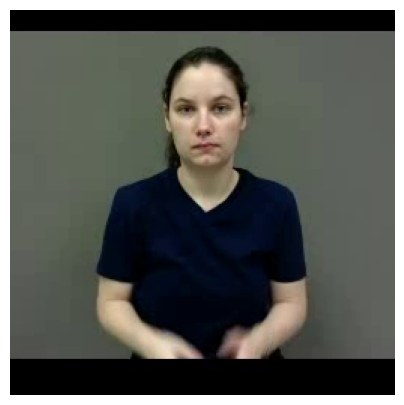

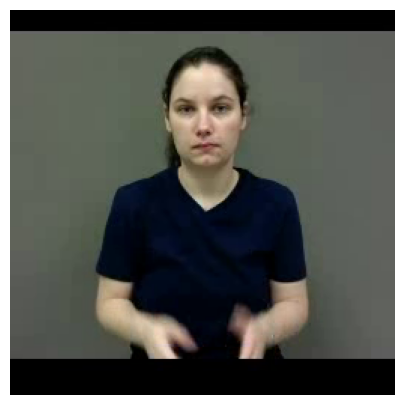

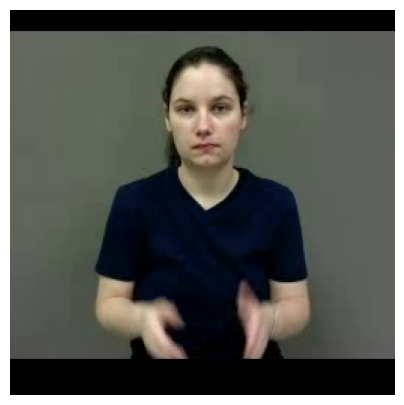

Shuffled indices:
tensor([2, 3, 0, 1])


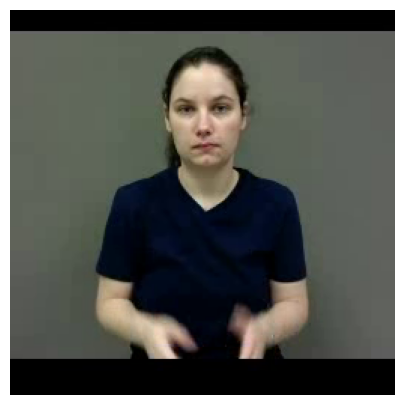

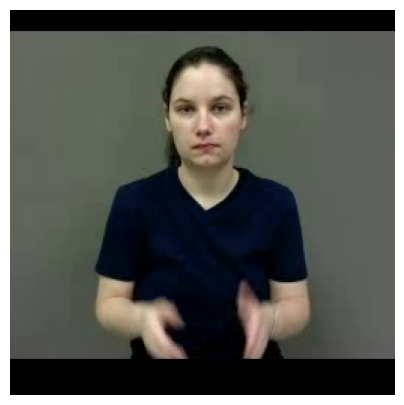

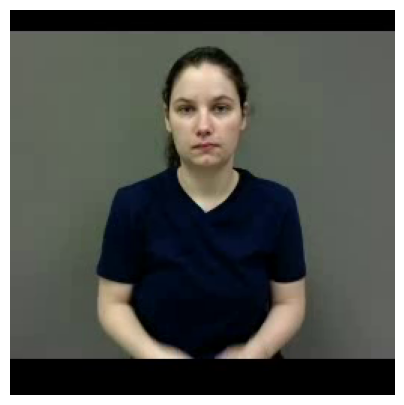

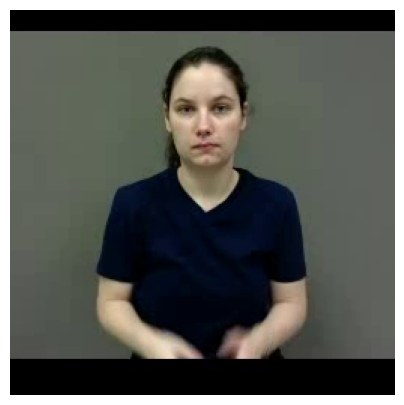

In [2]:
vid = './media/69241.mp4'
num_frames = 4
frames = utils.load_rgb_frames_from_video(vid, 4, 4+num_frames)
# print(frames.shape)
utils.visualise_frames(frames, num_frames)

# shuffled_indices = torch.randperm(frames.size(0))
shuffled_indices = Shuffle.create_permutation(frames.size(0), seed=42)
print("Shuffled indices:")
print(shuffled_indices)
t = ts.Compose([
  Shuffle(shuffled_indices)
])

f2 = t(frames)

# print(f2.shape)
utils.visualise_frames(f2,num_frames)

torch.Size([4, 3, 256, 256])


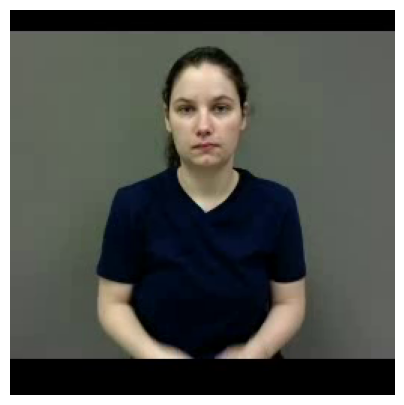

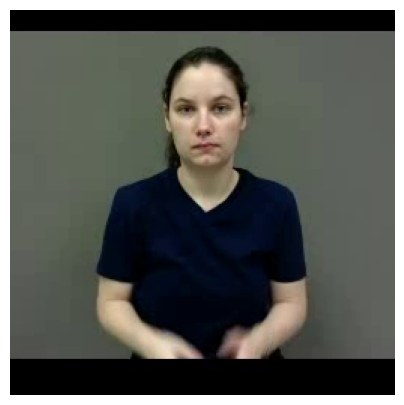

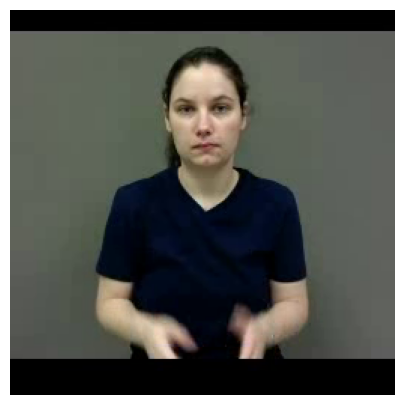

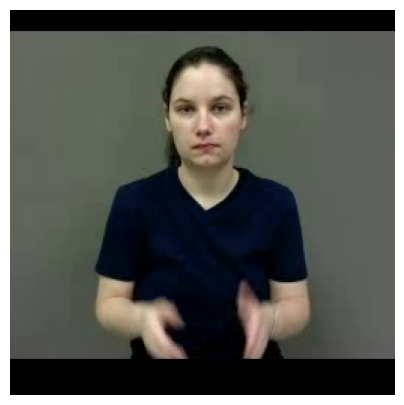

In [3]:
unshuffled = t(f2)

print(unshuffled.shape)
utils.visualise_frames(unshuffled,num_frames)

In [4]:
print("EQUAL: ", torch.allclose(frames, unshuffled))

EQUAL:  True


# Now testing from a video dataset perspective

In [2]:
root = Path('../data/WLASL/WLASL2000')
split = 'asl100'
all_labels = Path('./preprocessed/labels')
labels = all_labels / split
classes_path = Path('wlasl_class_list.json')
imp_path = Path('wlasl_implemented_info.json')

### Dataset

In [ ]:
num_frames = 16
frame_size = 224
test_instances = labels / 'test_instances_fixed_frange_bboxes_len.json'
test_classes = labels / 'test_classes_fixed_frange_bboxes_len.json'


In [6]:
permutation = Shuffle.create_permutation(num_frames, seed=42)

shuff_final_t = ts.Compose([
    Shuffle(permutation),
    ts.Lambda(lambda x: x.float() / 255.0),
	ts.Lambda(lambda x: x.permute(1,0,2,3))    
])
test_transforms = ts.Compose([ts.CenterCrop(frame_size),
							            shuff_final_t])

test_set = VideoDataset(root, test_instances, test_classes,
						transforms=test_transforms, num_frames=
						num_frames)
test_loader = DataLoader(test_set,
						batch_size=1, shuffle=True, num_workers=2,pin_memory=False, drop_last=False)
num_classes = len(set(test_set.classes))
print(f'Number of samples: {len(test_set)}')
print(f'Number of classes: {num_classes}')

Number of samples: 258
Number of classes: 100


### Load Thursday 2 sign video 

I have worked with this video fairly extensively

In [13]:
thurs2_idx = 257
with open(classes_path, 'r') as f:
    class_list = json.load(f)

thurs2 = test_set.data[thurs2_idx]
utils.print_dict(thurs2)
print(class_list[thurs2['label_num']])

{
label_num : 99
frame_end : 92
frame_start : 0
video_id : 70026
bbox : [61, 30, 199, 235]
}

thursday


### Without transform (manual load does not apply)

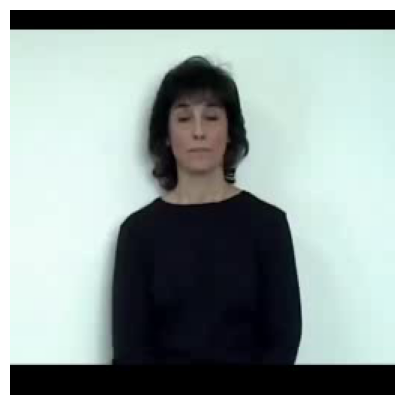

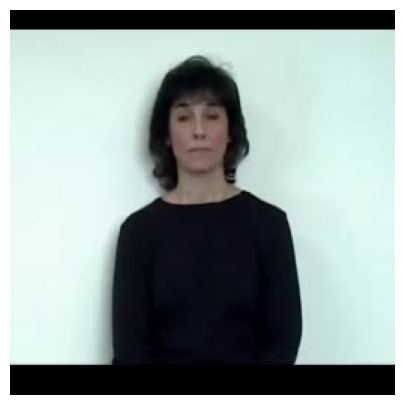

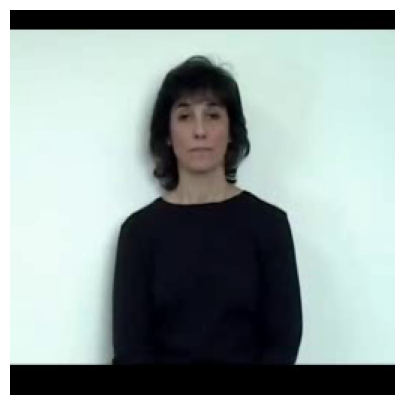

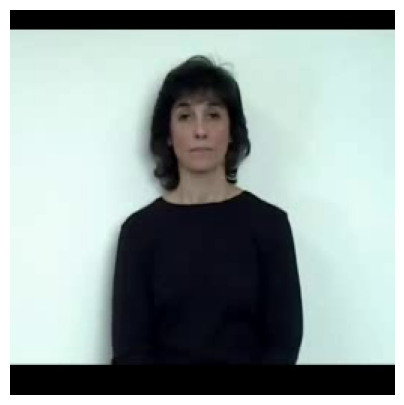

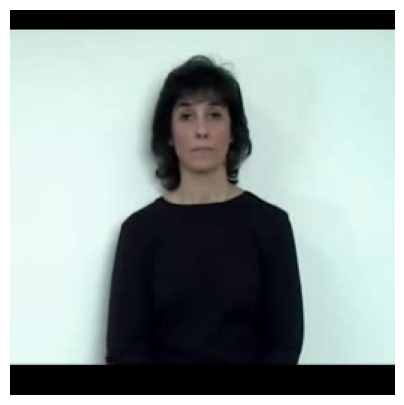

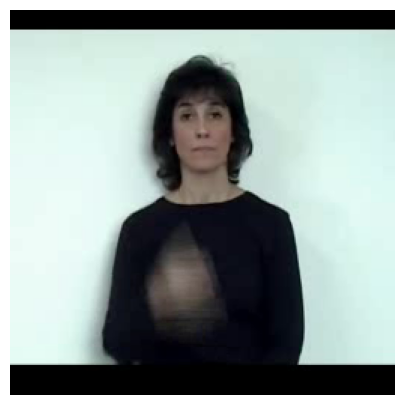

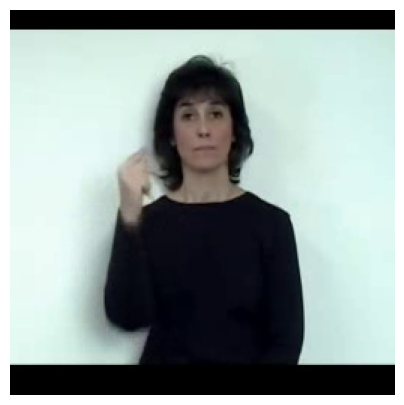

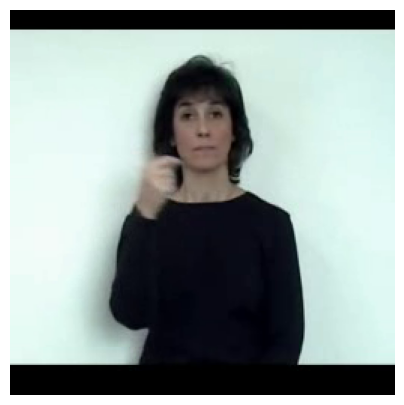

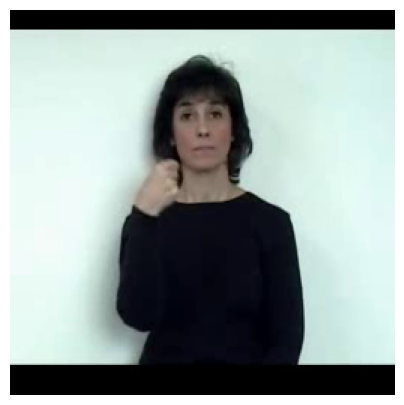

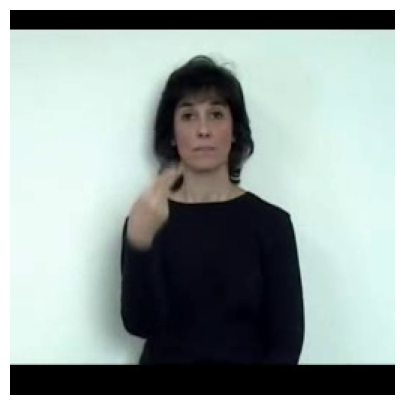

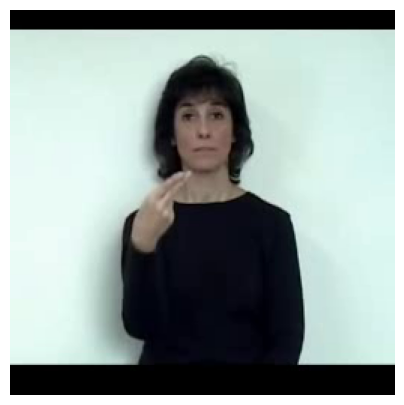

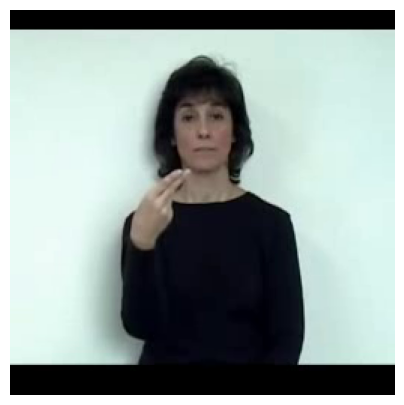

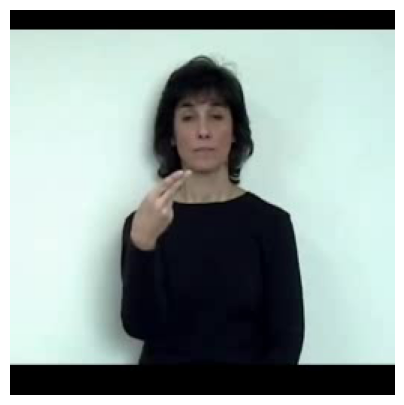

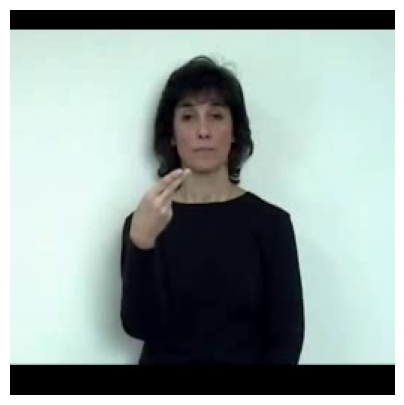

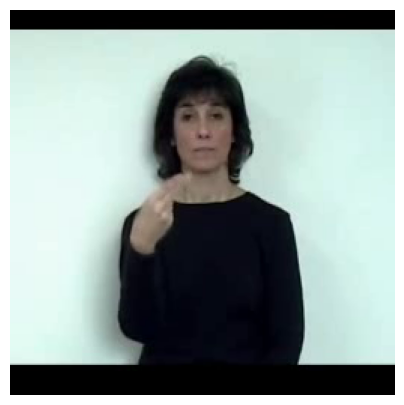

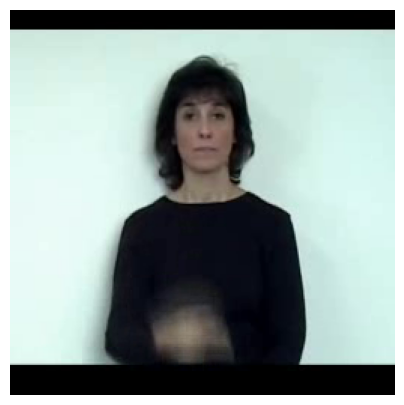

In [11]:
frames = test_set.__manual_load__(thurs2)
utils.visualise_frames(frames, num_frames)

In [12]:
print(permutation)

tensor([ 6,  3,  0,  7, 10, 15,  2, 12, 14,  9,  8,  5,  4, 13, 11,  1])


### With transform

In [14]:
result = test_set.__getitem__(thurs2_idx)
tframes = result['frames'] 
#remember to unpermute the frames
print(tframes.shape)

torch.Size([3, 16, 224, 224])


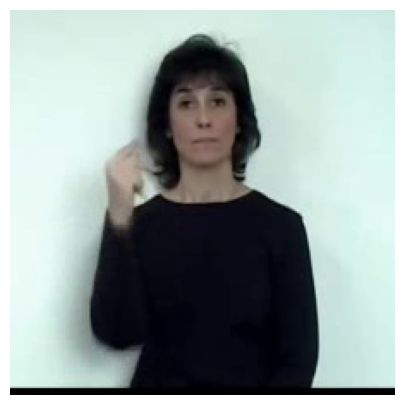

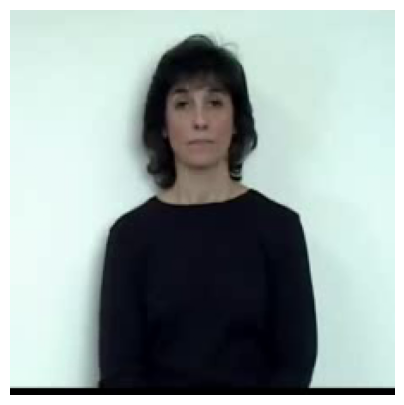

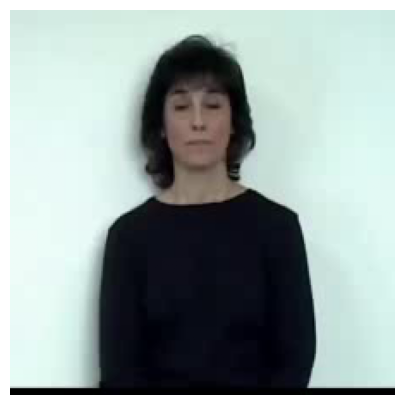

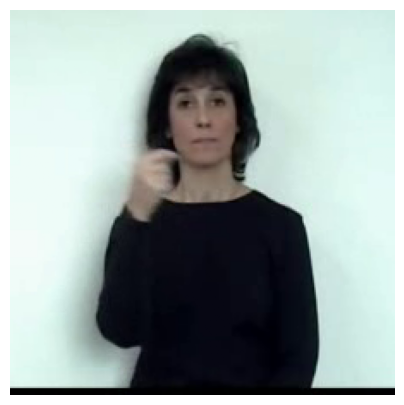

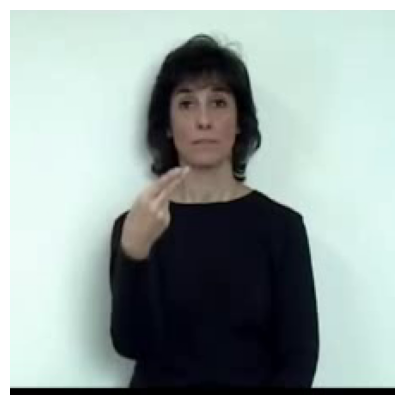

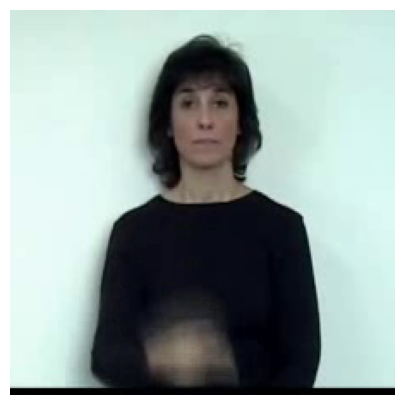

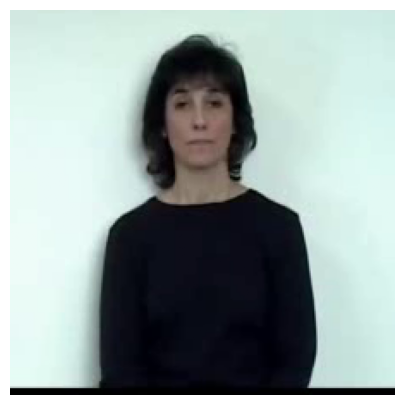

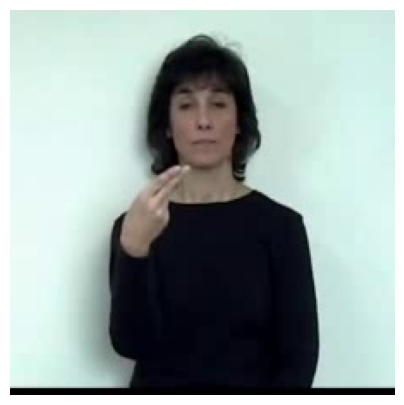

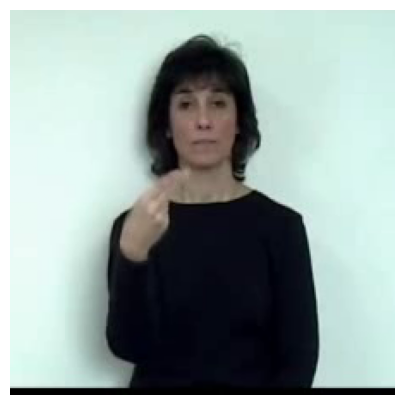

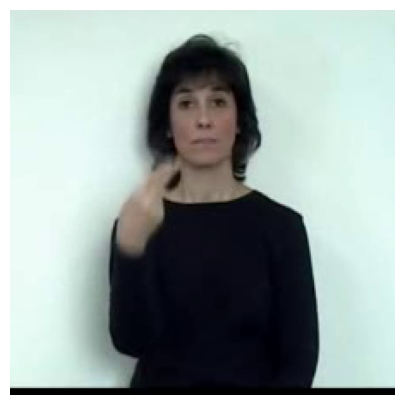

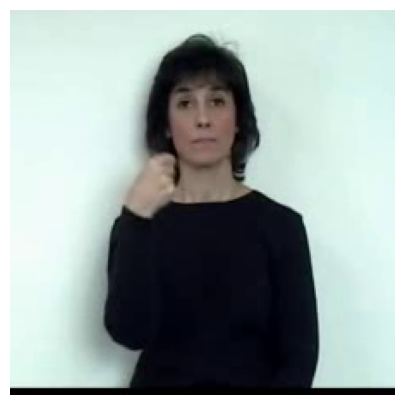

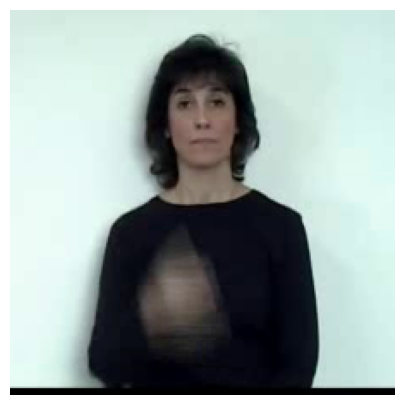

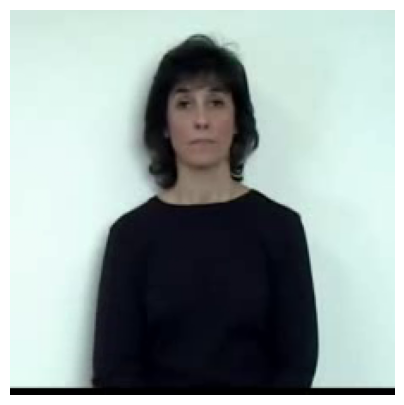

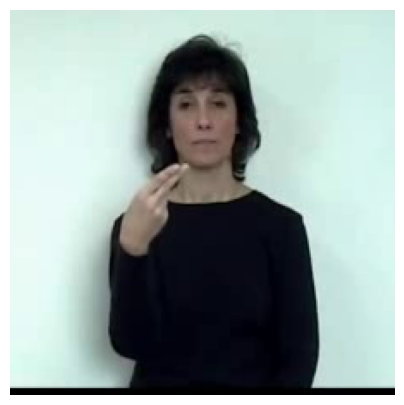

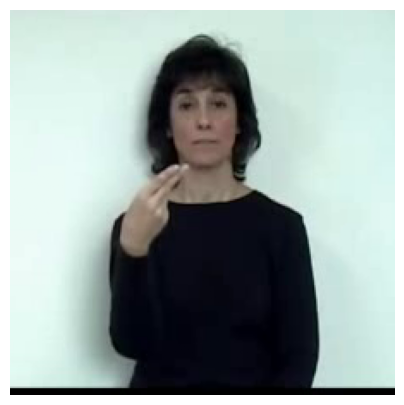

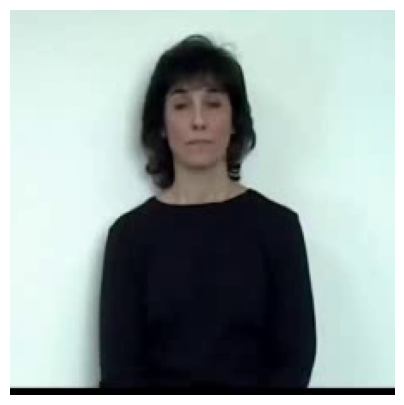

In [15]:
tframes = tframes.permute(1, 0, 2, 3)
utils.visualise_frames(tframes, num_frames)

# Through visual inspection, it appears that the added shufflign transform is workign as exected